In [1]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

### Data Load
- train_id: 데이터 id
- name: 제품명
- item_condition_id: 판매자가 제공하는 제품 상태
- category_name: 카테고리 명 ex) 가장 큰 카테고리 / 중간 카테고리 / 작은 카테고리
- brand_name: 브랜드 이름
- price: 제품 가격. 예측을 위한 타깃 속성
- shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
- item_description: 제품에 대한 설명

In [2]:
import numpy as np
import pandas as pd

train = pd.read_csv('mercari_train.tsv', sep='\t') # tab으로 seperate 줘야됨
print(train.shape)
train.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### 타깃 분포도 확인
- 회귀 모델을 하기 전에 확인해야 할 것은 타깃값이 정규분포를 이루느냐를 확인해야 한다.

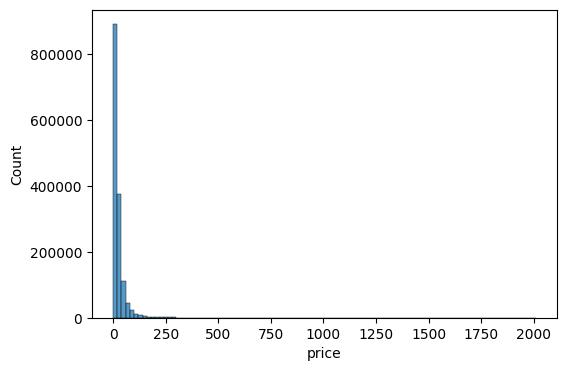

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

y_train_df = train['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

#### 타깃 값 로그변환 후 분포 확인

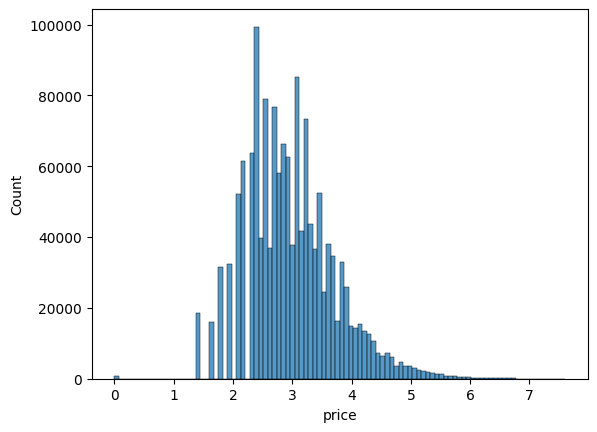

In [4]:
y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=100)
plt.show()

In [5]:
train['price'] = y_train_df
train['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [6]:
# 다른 feature 확인해보기
print('Shipping 값 유형:\n',train['shipping'].value_counts())
print('item_condition_id 값 유형:\n',train['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [7]:
# discription 에 'No discription yet'이 몇 건 있는지 확인
train[train['item_description'] == 'No description yet']['item_description'].count()

82489

#### category name이 대/중/소 와 같이 '/' 문자열 기반으로 되어 있음. 이를 개별 컬럼들로 재 생성

In [8]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

train['cat_dae'], train['cat_jung'], train['cat_so'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', train['cat_dae'].value_counts())
print('중분류 갯수 :', train['cat_jung'].nunique())
print('소분류 갯수 :', train['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


#### null 값 처리

In [9]:
train['category_name'] = train['category_name'].fillna('Other_Null')
train['brand_name'] = train['brand_name'].fillna('Other_Null')
train['item_description'] = train['item_description'].fillna('Other_Null')

train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   cat_dae            1482535 non-null  object 
 9   cat_jung           1482535 non-null  object 
 10  cat_so             1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


### Feature Encoding & Feature Vectorization
- Feature를 카테고리 형태로 변환할 수 있느냐 없느냐로 정함
- name, item_description은 feaeture Vectorization
- cat_dea, cat_jung, cat_so, brand_name은 feature encoding 

In [11]:
print('brand name 의 유형 건수 :', train['brand_name'].nunique())
print('brand name sample 5건 : \n', train['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [12]:
print('name 의 종류 갯수 :', train['name'].nunique())
print('name sample 7건 : \n', train['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',train['item_description'].str.len().mean())

train['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [14]:
import gc 
gc.collect()


0

#### name은 Count로, item_description은 TF-IDF로 피처 벡터화

In [15]:
# name은 count로
cnt_vect = CountVectorizer()
X_name = cnt_vect.fit_transform(train['name'])

tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(train['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [16]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# 원-핫 인코딩을 적용합니다. 
oh_encoder = OneHotEncoder()

# 원-핫 인코더를 할때는 반드시 2차원이 되어야함.
X_brand = oh_encoder.fit_transform(train['brand_name'].values.reshape(-1,1))
X_item_cond_id = oh_encoder.fit_transform(train['item_condition_id'].values.reshape(-1, 1))
X_shipping = oh_encoder.fit_transform(train['shipping'].values.reshape(-1, 1))
X_cat_dae= oh_encoder.fit_transform(train['cat_dae'].values.reshape(-1, 1))
X_cat_jung = oh_encoder.fit_transform(train['cat_jung'].values.reshape(-1, 1))
X_cat_so = oh_encoder.fit_transform(train['cat_so'].values.reshape(-1, 1))

In [17]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 2), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


#### 피처 벡터화된 희소 행렬과 원-핫 인코딩된 희소 행렬을 모두 scipy 패키지의 hstack()함수를 이용하여 결합

In [20]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung,X_cat_so)

# scipy.sparse hstack 모듈을 이용해 앞에서 encoding과 Vectorization 수행한 피쳐를 결합
# hstack를 하려면 column을 기준으로 결합하는 것이기 때문에 rows 수는 다 맞아야 함
X_feature = hstack(sparse_matrix_list).tocsr() # 희소행렬로 만든다는 의미 
print(type(X_feature), X_feature.shape) # 확인해보면 rows는 모두 동일하게 1482535임을 알수있음

# 메모리 많이 잡아먹으니까 바로 지워주기
del X_feature
gc.collect()


<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161570)


826

#### 릿지 회귀 모델 구축 및 평가
**RMSLE 정의**

In [28]:
def get_rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

# 원본데이터는 log1p가 변환되었으므로 expm1으로 원복 필요
def evaluate_ori_price(y_test, preds):
    preds_expm = np.expm1(preds)
    y_test_expm = np.expm1(y_test)
    
    rmsle = get_rmsle(y_test_expm, preds_expm)
    return rmsle

#### 여러 모델에 대한 학습/예측을 수행하기 위해 별도의 함수인 model_train_predict()생성

In [23]:
def model_train_predict(model, matrix_list):
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, train['price'], test_size=0.2, random_state=156)
    
    # model training
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return y_test, preds

#### 릿지 선형 회귀로 학습/예측/평가. Item Description 피처의 영향도를 알아보기 위한 테스트 함께 수행

In [24]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list =  (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_ori_price(y_test , linear_preds))

sparse_matrix_list =  (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print('Item Description을 포함했을 때 rmsle 값:', evaluate_ori_price(y_test , linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.06418032113753393
Item Description을 포함했을 때 rmsle 값: 0.04912276288811233


In [25]:
import gc
gc.collect()

0

#### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [26]:
from lightgbm import  LGBMRegressor

sparse_matrix_list =(X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(lgbm_model, sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_ori_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.0438163121653441


In [27]:
preds = lgbm_preds*0.45 + linear_preds*0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_ori_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.04381631216534413
